# Bycicle Counter Prediction

In [252]:
# imports
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# NOTES

- prohibited to select on the month of july

## TO DO

- check for assumptions
    - if multicollinearity --> principal component regression better than regular linear regression, also good to do in exploratory part

- add vacation binary
- add gentse feesten binary
- include summer in training

In [205]:
# Download weather data
!curl 'https://archive-api.open-meteo.com/v1/archive?latitude=51.100006&longitude=3.699997&start_date=2023-01-01&end_date=2023-06-30&hourly=temperature_2m,precipitation,rain,snowfall,snow_depth,cloudcover,windspeed_10m,windgusts_10m&format=csv' -o 'data/weather_data_full.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  230k    0  230k    0     0   600k      0 --:--:-- --:--:-- --:--:--  606k


In [237]:
# Load in data
train_data = pd.read_csv('./data/train_data.csv')
weather_data = pd.read_csv('./data/weather_data_full.csv',skiprows=3)
test_data = pd.read_csv('./data/test_data.csv')


In [238]:
# 1. Preprocessing

## Make sure the number of datapoints is equal
min_length = min(train_data.shape[0], weather_data.shape[0])
weather_data = weather_data.iloc[:min_length]
## Make sure the time formatting is equal
weather_data['time'] = weather_data['time'].str[:-3]
# Merge train data with the variables
train_data_full = pd.concat([weather_data, train_data['Totaal']], axis=1)
# Drop columns where all values are equal (mostly to filter out the 0-only columns)
same_value_columns = train_data_full.columns[train_data_full.apply(pd.Series.nunique) == 1]
train_data_full = train_data_full.drop(same_value_columns, axis=1)

In [239]:
# extract hours into dummy variables

train_data_full['hour'] = train_data_full['time'].str.split('T').str[1].str.split(':').str[0].astype(int)
train_data_full = pd.get_dummies(train_data_full, columns=['hour'], prefix='hour', prefix_sep='_', drop_first=True)


In [240]:
# weekends
## first make sure time is in datetime format
train_data_full['time'] = pd.to_datetime(train_data_full['time'])

# Create a new column 'is_weekend' with binary values (0 for weekdays, 1 for weekends).
train_data_full['is_weekend'] = (train_data_full['time'].dt.dayofweek >= 5).astype(int)

In [241]:
# drop time
train_data_full = train_data_full.drop('time', axis=1)

In [ ]:
#2. Exploratory Data Analysis

/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

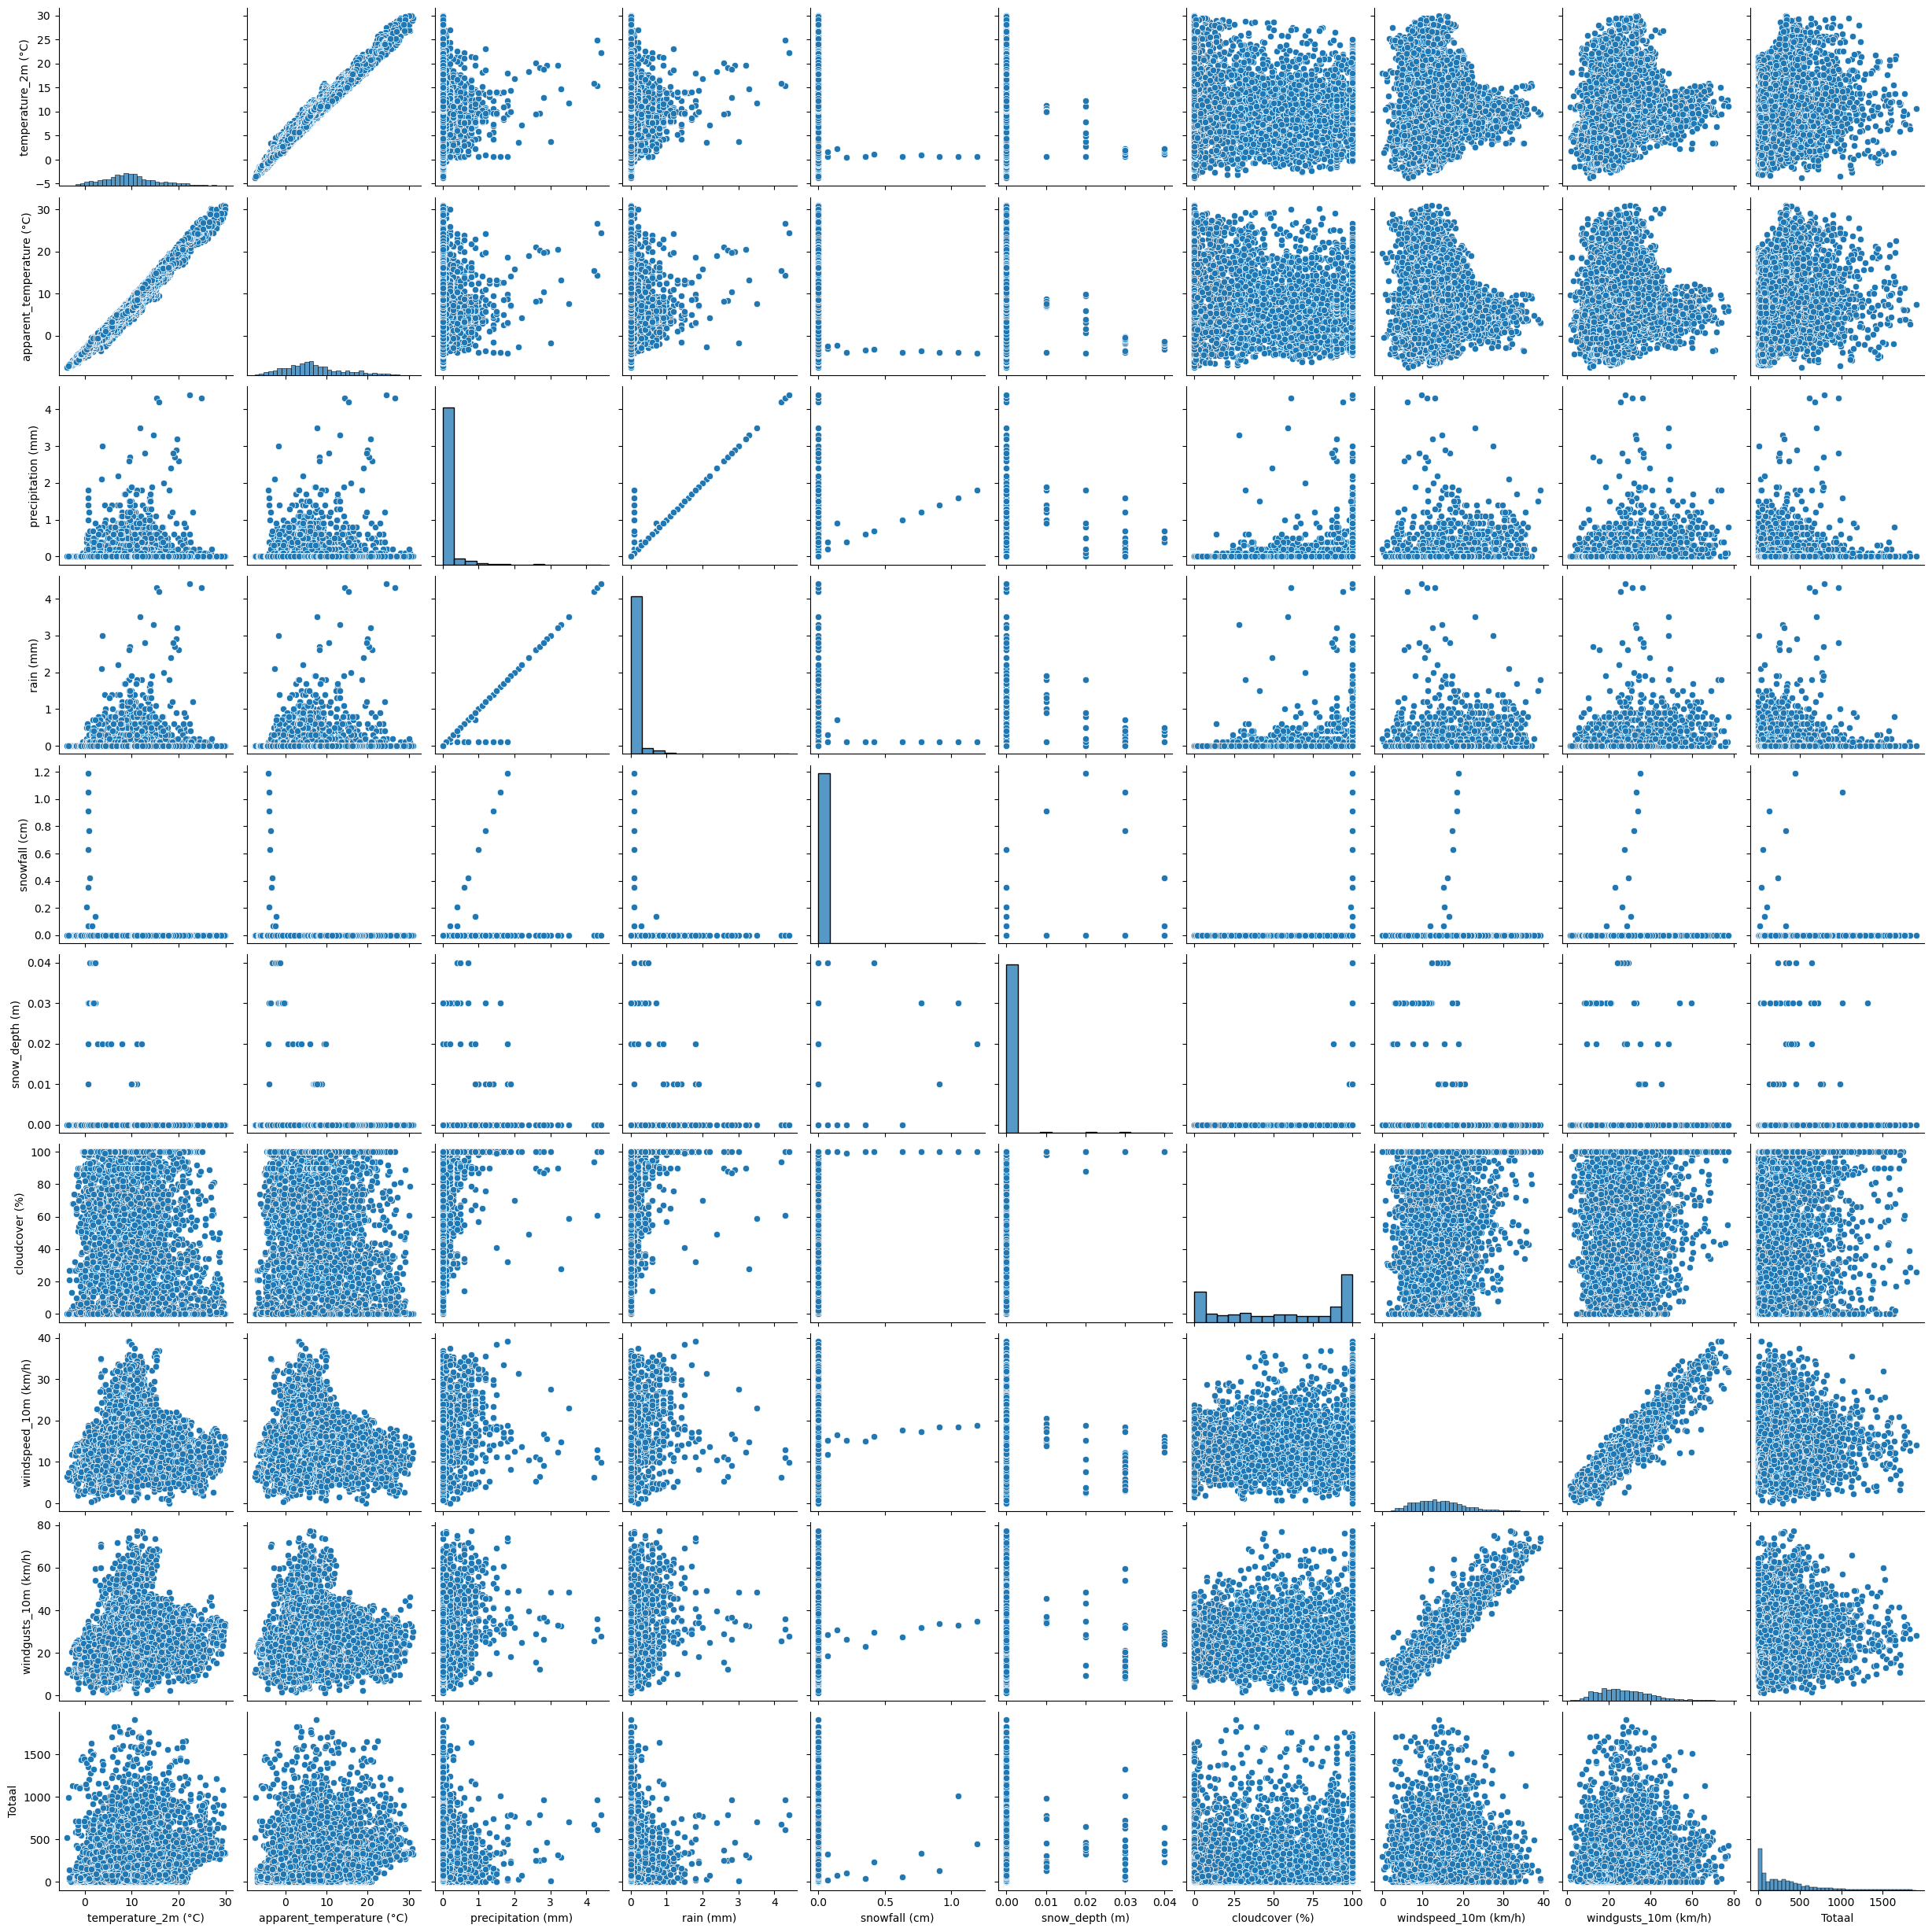

In [134]:
pairplot = sns.pairplot(train_data_full)
pairplot.savefig('figures/pairplot')

In [251]:
## Correlation analysis



# Calculate the correlation matrix between all features and the target variable
correlation_matrix = train_data_full.corr()

# Extract the correlation of features with the target variable 'Totaal'
correlation_with_target = correlation_matrix['Totaal'].drop('Totaal')

# Sort the features by their correlation values
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Print the correlation values for each feature
print(correlation_with_target)


is_weekend              0.286262
hour_7                  0.239718
temperature_2m (°C)     0.239103
hour_16                 0.233489
hour_17                 0.207692
hour_2                  0.184537
hour_3                  0.182881
hour_8                  0.181657
hour_1                  0.176090
hour_4                  0.171115
hour_15                 0.156313
hour_5                  0.143909
hour_23                 0.132994
windgusts_10m (km/h)    0.100675
hour_18                 0.099378
hour_22                 0.095809
hour_14                 0.069701
hour_12                 0.067929
hour_21                 0.065841
hour_11                 0.054340
hour_20                 0.050553
hour_13                 0.043219
windspeed_10m (km/h)    0.027736
snow_depth (m)          0.025230
precipitation (mm)      0.019053
rain (mm)               0.017900
hour_9                  0.012929
snowfall (cm)           0.008881
cloudcover (%)          0.002886
hour_19                 0.002221
hour_6    

In [ ]:
# 3. splitting the data

In [244]:
## Put data in numpy arrays
y = train_data_full.Totaal.values
X = train_data_full.drop('Totaal', axis=1).values

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) # Use 70% of data for training

# 4. Linear regression

In [246]:
from sklearn.linear_model import LinearRegression


LinReg = LinearRegression() # call an instance of the class LinearRegression

LinReg.fit(X_train, y_train) # fit the model on the training data
y_hat_train = LinReg.predict(X_train) # predict training data
MSE_train = mean_squared_error(y_train, y_hat_train) # Compute training set MSE

y_hat_test = LinReg.predict(X_test) # predict test data
MSE_test = mean_squared_error(y_test, y_hat_test) # Test set MSE

R_train = LinReg.score(X_train, y_train) # Training set R²
R_test = LinReg.score(X_test, y_test) # Test set R²

print('Training set MSE: {}'.format(MSE_train))
print('Test set MSE: {}'.format(MSE_test))
print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))

Training set MSE: 46381.25537207779
Test set MSE: 51239.14688117773
Train set R²: 0.5310670122753103
Test set R²: 0.517182276790783


# 4 XGboost

In [253]:
# Initialize the XGBoost model
model = XGBRegressor(objective='reg:squarederror')

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")



Mean Squared Error: 42780.66167685218
R-squared: 0.5968851371374196
